In [2]:
name="GSE199460_original3000_preprocessed"
input_path = f"./data/{name}.h5ad"

In [ ]:
%run ScCM.py \
--input_h5ad_path={input_path} 

computing PCA
    with n_comps=50
    finished (0:00:00)


/tmp/ipykernel_984595/973957839.py:6: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=count_frame)
/geniusland/home/fangyi/anaconda3/envs/pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


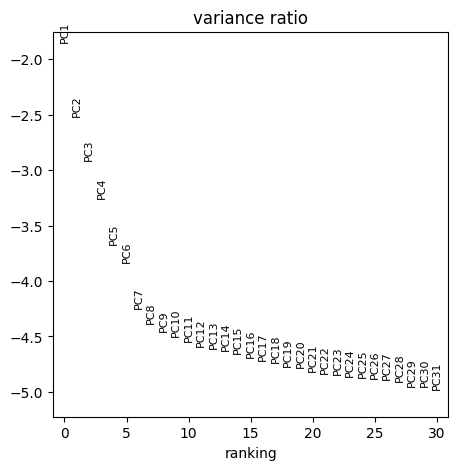

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:06)
running Leiden clustering
    finished (0:00:07)
computing UMAP
    finished (0:00:19)


In [16]:
import numpy as np
import pandas as pd
import scanpy as sc
count_csv_path = f"./results/scCM/feature_scCM_{name}.csv"
count_frame = pd.read_csv(count_csv_path, index_col=None, header=None, )
adata = sc.AnnData(X=count_frame) # Create an AnnData object from the count data
sc.tl.pca(adata, svd_solver='arpack') # Perform PCA analysis on the count data
sc.pl.pca_variance_ratio(adata, log=True) # Plot the variance ratio of the principal components
sc.pp.neighbors(adata, n_neighbors=35,n_pcs=40) # Compute the neighborhood graph using PCA dimensions
sc.tl.leiden(adata,resolution=1) # Perform Leiden clustering on the neighborhood graph
sc.tl.umap(adata,min_dist=0.4) # Compute UMAP embeddings of the count data

# Read the original AnnData object from an H5AD file
adata_o = sc.read_h5ad("./data/GSE199460_original.h5ad")
adata.obs.index=adata_o.obs.index
adata_o.obsm['X_umap']=adata.obsm['X_umap'] # Copy the UMAP embeddings from the new AnnData object to the original object
adata_o.obs['leiden']=adata.obs['leiden']

/geniusland/home/fangyi/anaconda3/envs/pytorch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


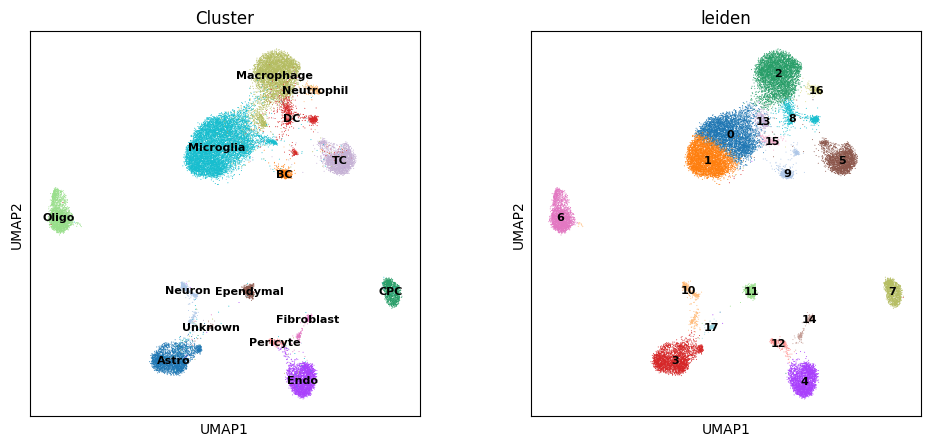

In [9]:
import matplotlib.pyplot as plt
import scanpy.plotting as scplt
plt.rcParams['figure.figsize'] = [5, 5]
# Plot UMAP embeddings of the original AnnData object
scplt.umap(adata_o, color=['Cluster','leiden'], 
           legend_loc='on data',
           add_outline=False,
           legend_fontsize = 8,
           size=2,
           frameon=True,)

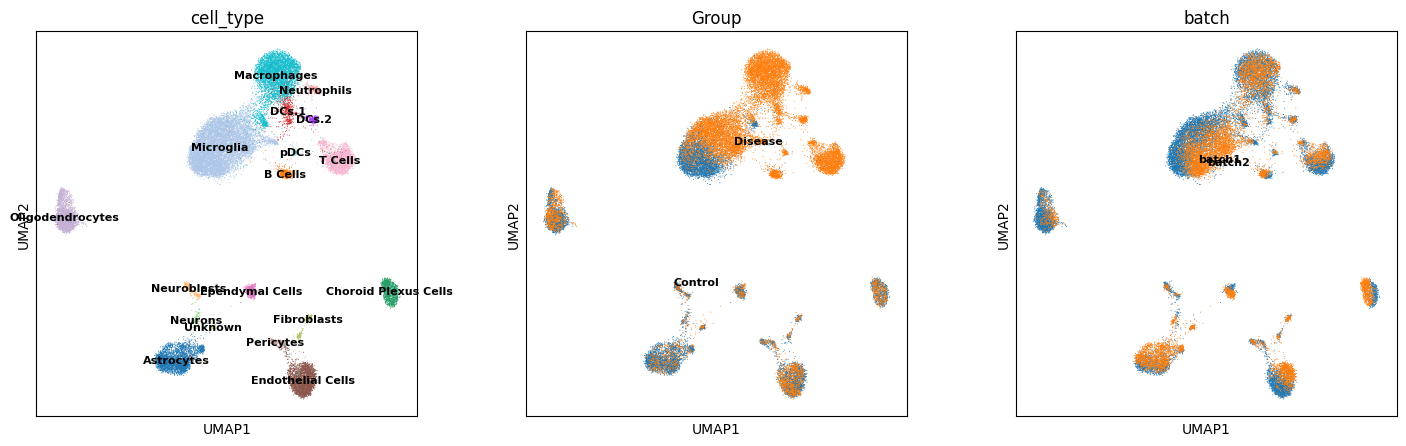

In [10]:
scplt.umap(adata_o, color=['cell_type','Group', 'batch'], 
           legend_loc='on data',
           add_outline=False,
           legend_fontsize = 8,
           size=2,
           frameon=True,)

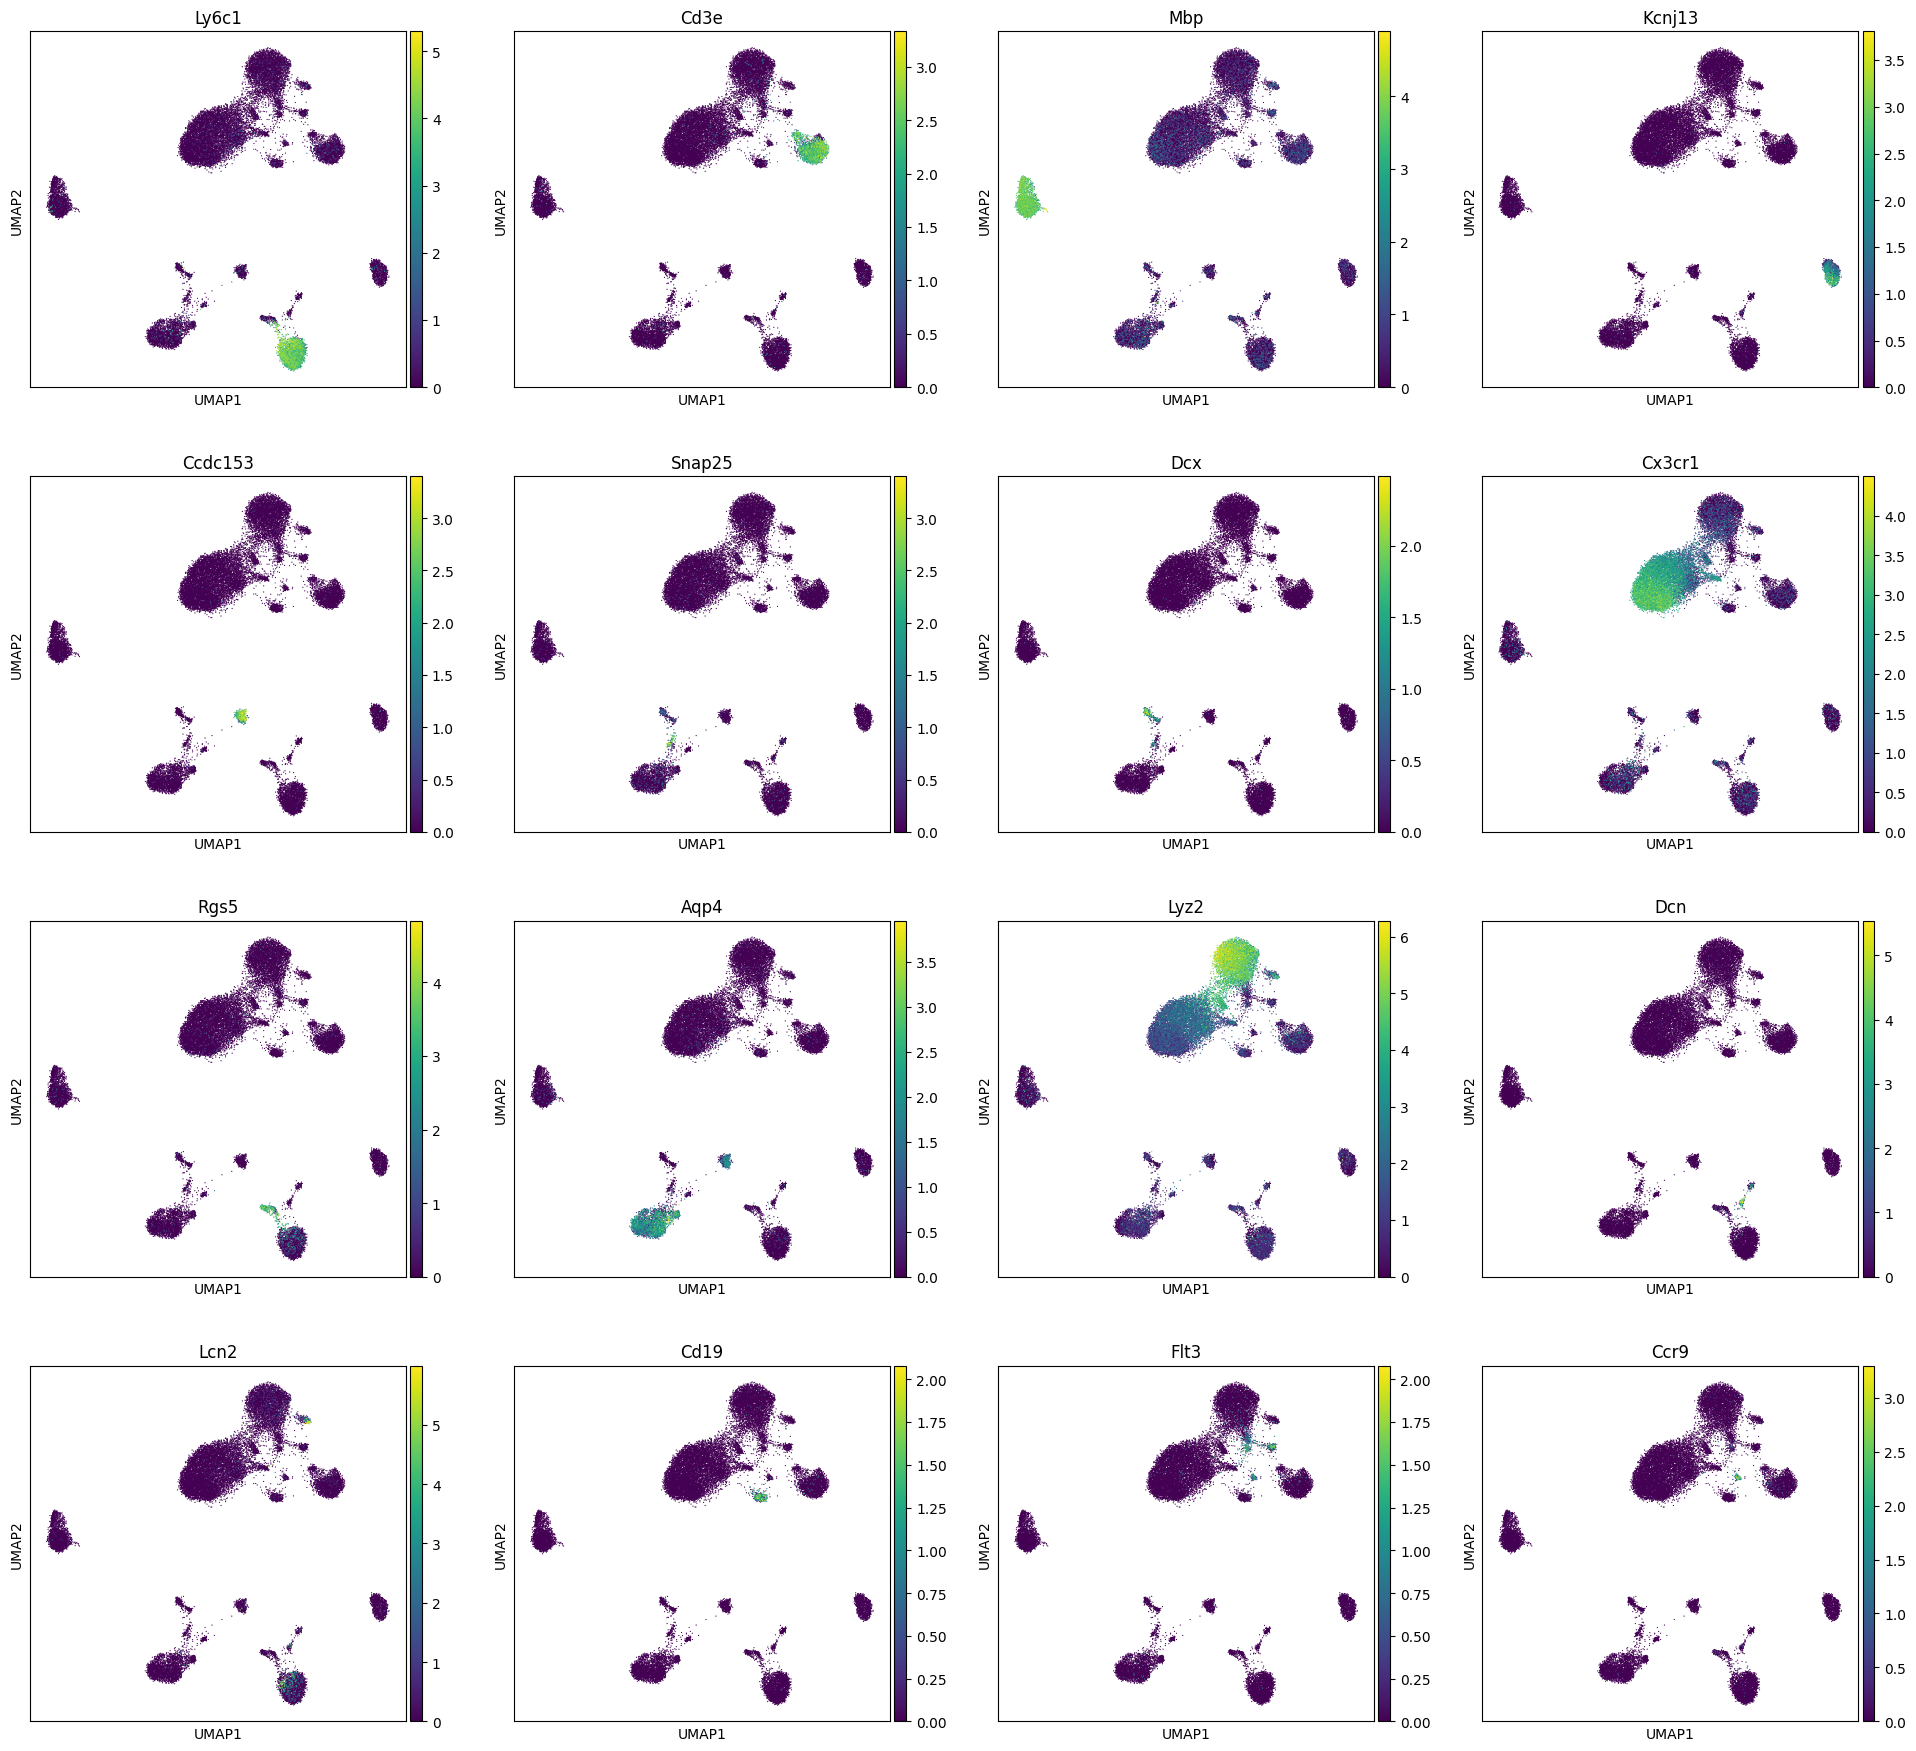

In [11]:
import scanpy.plotting as scplt
# Marker genes of clusters
scplt.umap(adata_o, color=[
    'Ly6c1','Cd3e','Mbp','Kcnj13','Ccdc153',
    'Snap25','Dcx','Cx3cr1','Rgs5','Aqp4',
    'Lyz2','Dcn','Lcn2','Cd19','Flt3','Ccr9'    
                          ], 
           legend_loc='on data',
           add_outline=False,
           legend_fontsize=10, 
           legend_fontoutline=0.5,
           size=3 ,frameon=True,)

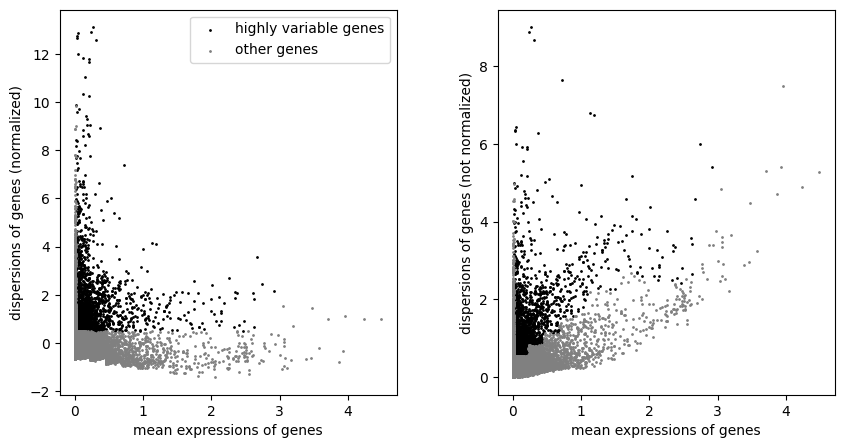

AnnData object with n_obs × n_vars = 26821 × 19496
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'cell_type', 'cell type', 'Cluster', 'cns_resident', 'condition', 'UMAP_1', 'UMAP_2', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ERCC', 'pct_counts_ERCC', 'leiden', 'Cluster_M', 'Group'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ERCC', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cluster_colors', 'batch_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'leiden_colors', 'cell_type_colors', 'Group_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
adata = adata_o.copy()
sc.pp.filter_cells(adata,  min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
# annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'],percent_top=None, 
                           log1p=False,inplace=True)

adata = adata[adata.obs.n_genes_by_counts <5000, :]
adata = adata[adata.obs.pct_counts_mt <10, :]
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata,min_mean=0.0125, 
                            max_mean=3,min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata

ranking genes
    finished (0:01:09)


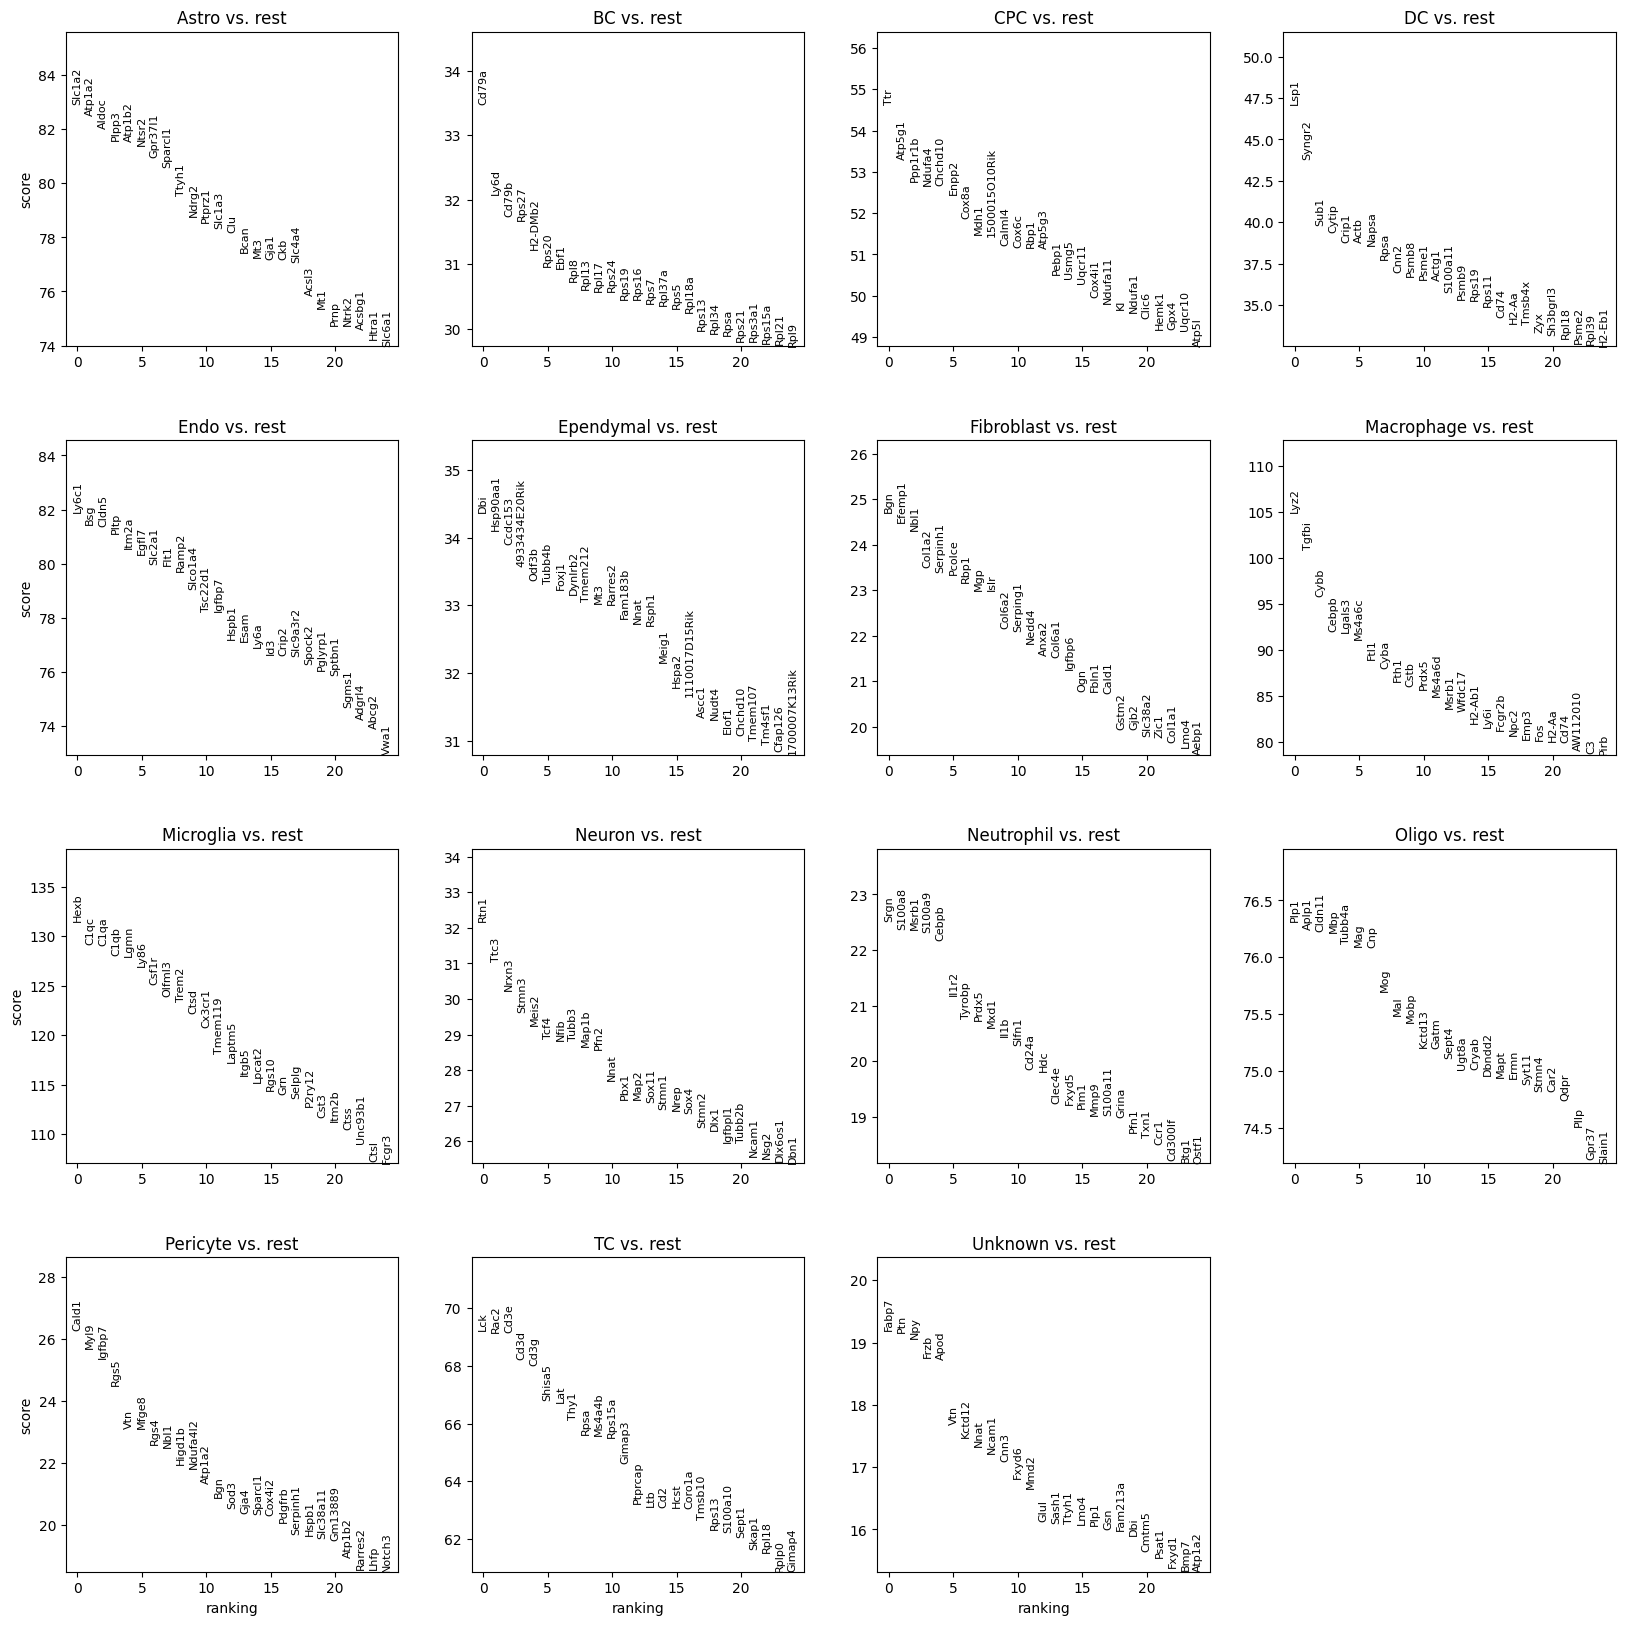

In [14]:
sc.settings.verbosity = 2 
sc.tl.rank_genes_groups(adata, 'Cluster', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Cluster']`
categories: Astro, BC, CPC, etc.
var_group_labels: Endothelial Cells, Fibroblasts, Pericytes, etc.


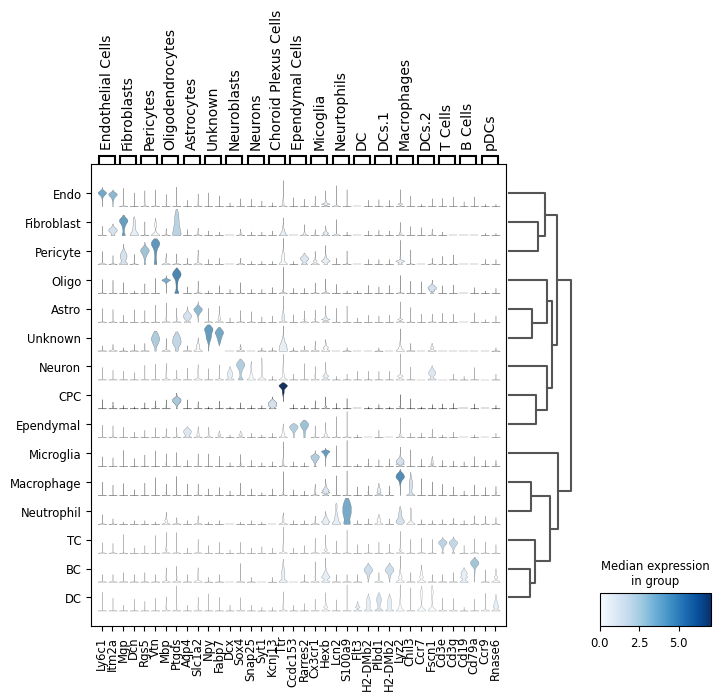

In [15]:
%matplotlib inline
adata_o.var_names_make_unique()
marker_genes_dict = {
    'Endothelial Cells': ['Ly6c1','Itm2a',],
    'Fibroblasts':['Mgp','Dcn'],
    'Pericytes':['Rgs5','Vtn',],
    'Oligodendrocytes':['Mbp','Ptgds'],
    'Astrocytes':['Aqp4','Slc1a2',],
    'Unknown':['Npy','Fabp7'],       
    'Neuroblasts':['Dcx','Sox4',],
    'Neurons':['Snap25','Syt1'],
    'Choroid Plexus Cells':['Kcnj13','Ttr'],
    'Ependymal Cells':['Ccdc153','Rarres2'],
    'Micoglia': ['Cx3cr1','Hexb'],
    'Neurtophils':['Lcn2','S100a9'],
    'DC':['Flt3','H2-DMb2'],
    'DCs.1':['Plbd1','H2-DMb2'],
    'Macrophages':['Lyz2','Chil3'],
    'DCs.2':['Ccr7','Fscn1'],
    'T Cells':['Cd3e','Cd3g'], 
    'B Cells':['Cd19','Cd79a',], 
    'pDCs':['Ccr9','Rnase6',],
}
sc.tl.dendrogram(adata_o, groupby='Cluster')
sc.pl.stacked_violin(adata_o, marker_genes_dict, 
                     groupby='Cluster', swap_axes=False, 
                     dendrogram=True,
                     figsize=(8, 6),)

running PAGA
    finished (0:00:01)


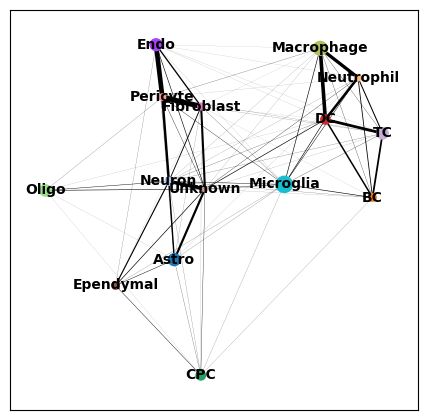

In [17]:
adata.obs['Cluster']=adata_o.obs['Cluster']
sc.tl.paga(adata, groups='Cluster')
sc.pl.paga(
    adata, 
    color=['Cluster'],
    node_size_scale=0.3,
    edge_width_scale=0.5
)